In [1]:
# 기본적인 라이브러리(기초세션에서 다룸)
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 구글 드라이브 연동

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 문제 1

사용할 데이터 : house.csv

네이버 부동산에서 크롤링해 가져온 서울시 부동산 데이터

* Unnamed: 0 : 의미없는 칼럼
* id : 매물id
> 한 매물당 하나의 id가 할당된다.
* lat : 위도
* lng : 경도
* gu : 구(행정지역정보)
* goodsType : 매물의 거래형태(아파트,빌라 등)
* payType : 판매의 거래형태(월세,매매 등)
* floor : 매물방의 층수
* floor_total : 매물이 있는 전체 건물의 층수
* contractArea : 계약면적
* realArea : 실제면적
* direction : 창문방향(남향,북향)
* tag : 매물마다 관련된 설명정보
> ex. 일조량 및 관리 잘 된 복층
* tagList : 매물마다 관련된 설명에서의 태그
> ex. '10년이내, 25년이내 건축, 복층'과 같이 인스타 해시테그 느낌
* deposit : 보증금
* monthlyPay : 월세


> 데이터 출처 : 네이버 부동산 크롤링 데이터

설명
* X와 y를 찾아, LinearRegression을 위 예제1을 참고하여 실행하시오.
* 예를 들면, y='보증금', X=나머지 으로 하여 나머지 값으로 보증금을 예측하는 선형회귀문제로 Task를 정해 코딩을 진행

* 조건
> * ***(핵심내용)*** X & y로 이용할 것을 명확히 제시하고, y에 따른 어떤 문제인지 파악하기
>    * y를 연속형으로 하여, LinearRegression문제가 될 수 있도록 한다.
> * X변수에 1개이상의 범주형데이터를 포함하고, one-hot encoding을 사용하기
> * 최소 1가지 이상의 방법으로 X데이터 중 1개 이상의 열을 삭제하기
> * 데이터 분할 진행하기
> * ***(핵심내용)*** 다중선형회귀 모델을 사용하기
> * 규제항이 있는 모델(Ridge,Lasso)을 사용하기
> * hyper-parameter 튜닝을 진행하기
>   * cross_val_score를 사용하지 않아도 됩니다.
>   * GridSearchCV ,RandomSearchCV을 사용하셔도 됩니다.
>   * 참고자료 : https://dacon.io/codeshare/
> * ***(핵심내용)*** 변수 중요도 해석
>   * 스케일링 없이
>   * min-max scaling
>   * standard scaling

가정은 위와 동일

y='보증금', X=나머지

x에 범주형 변수를 여러개 추가했더니 다중공선성 부분 처리가 어려워서 x 범주형 변수는 payType만 포함함.

goodsType은 재건축, 오피스텔 분양권 등 보증금에 안 중요한 내용들도 있는 것 같고, 
지역보다는 월세/전세 등에 따라 보증금 차이가 더 크기 때문에 payType으로 결정.

## 데이터 불러오기

In [3]:
house_path = '/content/drive/MyDrive/Colab Notebooks/[0131][HW]_LinearRegression_and_SVM/house.csv'
house = pd.read_csv(house_path)
house.head()

,Unnamed: 0,id,lat,lng,gu,goodsType,payType,floor,floor_total,contractArea,realArea,direction,tag,tagList,deposit,monthlyPay
0,0,2233636969,37.677967,127.041725,dobong,아파트,매매,5,5,81,63,남향,ok. 일조량 및 관리 잘 된 복층,"['10년이내', '역세권', '복층', '탑층']",63000,0
1,3,2232935032,37.657623,127.044115,dobong,아파트,매매,15,24,154,119,남향,기본 로얄동 로얄층 채광 GOOD,"['25년이내', '대단지', '대형평수', '방네개이상']",140000,0
2,4,2232502309,37.645001,127.040034,dobong,빌라,전세,3,4,38,33,남향,올수리 베란다크고 주차 남향 초등학교 대형마트 재래시장 5분,"['25년이상', '융자금적은', '올수리', '화장실한개']",15000,0
3,5,2232883418,37.666850,127.039420,dobong,아파트,매매,5,18,107,84,남향,내부상태아주좋습니다 방학역세권 도깨비시장근접함 주인거주,"['25년이상', '방세개', '화장실두개', '주차가능']",60000,0
4,6,2234171117,37.655622,127.041475,dobong,사무실,월세,2,8,30,22,북향,빠른입주가능 상태깨끗 창동역도보7분 사무실강추,"['25년이내', '융자금없는', '주차가능', '북향']",700,44


In [4]:
house.columns

Index(['Unnamed: 0', 'id', 'lat', 'lng', 'gu', 'goodsType', 'payType', 'floor',
       'floor_total', 'contractArea', 'realArea', 'direction', 'tag',
       'tagList', 'deposit', 'monthlyPay'],
      dtype='object')

(array([9.2282e+04, 1.4300e+03, 1.8000e+02, 5.5000e+01, 2.6000e+01,
        6.0000e+00, 1.2000e+01, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([      0.,  240000.,  480000.,  720000.,  960000., 1200000.,
        1440000., 1680000., 1920000., 2160000., 2400000.]),
 <a list of 10 Patch objects>)

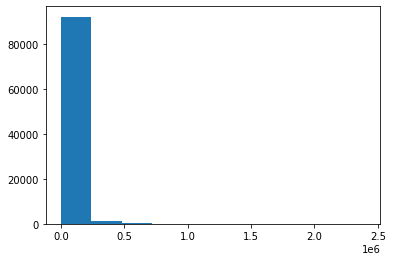

In [5]:
# y값
y_label = house.loc[:,'deposit']

y_label.value_counts()
plt.hist(y_label.values)

In [6]:
# 위의 y값을 제외한 진정한 X값들로 이루어진 features 만들기

X_features = house.drop(['deposit', 'id', 'tag', 'tagList'], axis=1)
X_features.columns # 11개의 열들이 진정한 X_features로 사용

Index(['Unnamed: 0', 'lat', 'lng', 'gu', 'goodsType', 'payType', 'floor',
       'floor_total', 'contractArea', 'realArea', 'direction', 'monthlyPay'],
      dtype='object')

In [7]:
X_features.head()

#범주형 데이터 : gu, goodsType, patType, direction, tag, tagList
#연속형 데이터 : lat, lng, floor, floor_total, contractArea, realArea, monthlyPay

,Unnamed: 0,lat,lng,gu,goodsType,payType,floor,floor_total,contractArea,realArea,direction,monthlyPay
0,0,37.677967,127.041725,dobong,아파트,매매,5,5,81,63,남향,0
1,3,37.657623,127.044115,dobong,아파트,매매,15,24,154,119,남향,0
2,4,37.645001,127.040034,dobong,빌라,전세,3,4,38,33,남향,0
3,5,37.666850,127.039420,dobong,아파트,매매,5,18,107,84,남향,0
4,6,37.655622,127.041475,dobong,사무실,월세,2,8,30,22,북향,44


In [13]:
house.loc[:,'gu'].value_counts()

gangseo         4097
guro            3983
yeongdeungpo    3974
seocho          3958
yangcheon       3902
nowon           3902
songpa          3901
guemcheon       3881
eunpyeong       3833
dobong          3784
gangdong        3784
dongjak         3748
mapo            3742
jungnang        3732
seongdong       3726
yongsan         3705
seongbuk        3703
gwangjin        3689
dongdaemun      3689
jung            3679
gangnam         3669
seodaemun       3661
gwanak          3654
gangbuk         3443
jongno          3156
Name: gu, dtype: int64

In [15]:
house.loc[:,'goodsType'].value_counts()

아파트        34639
빌라         17638
상가         13682
사무실        10686
원룸          5209
오피스텔        5138
단독/다가구      3761
지식산업센터      1522
재건축          549
상가주택         501
아파트분양권       447
오피스텔분양권      164
재개발           57
전원주택           1
한옥주택           1
Name: goodsType, dtype: int64

In [17]:
house.loc[:,'payType'].value_counts()

월세      37803
매매      30918
전세      24918
단기임대      356
Name: payType, dtype: int64

In [18]:
house.loc[:,'direction'].value_counts()

남향     29214
남동향    16395
남서향    13189
동향     13111
서향      7084
북향      5091
북동향     3664
북서향     3043
Name: direction, dtype: int64

In [20]:
house.loc[:,'tag'].value_counts()

핫한 청량리 인근 분양 후 즉시 임대차 가능한 원룸 매물    42
100강남최저가격                          36
선유나무 부동산 검색으로 경매예방 경험 보기           34
깔끔하고, 혼자 살기 좋은 방.                  31
올수리                                31
                                   ..
가성비 쓰리룸 전세 깔끔하고 좋아요                 1
확장.근린공원 조망.10월말11월초 입주              1
즉시 입주 가능한 방1                        1
구디역 직장인 환영 깔끔한 풀옵션 분리형 원룸           1
깨끗 오래거주가능 공실 추가수리                   1
Name: tag, Length: 82340, dtype: int64

In [21]:
house.loc[:,'tagList'].value_counts()

['2년이내', '융자금없는', '역세권']                2874
['25년이상', '융자금없는', '역세권', '1층']         2389
['25년이상', '융자금없는', '역세권', '주차가능']       1787
['10년이내', '융자금없는', '역세권']               1494
['25년이상', '융자금없는', '역세권']               1074
                                        ... 
['10년이내', '올수리', '급매', '방세개']              1
['융자금적은', '1층', '관리비20만원이하', '주차가능']       1
['25년이내', '융자금없는', '고층', '주차가능']           1
['융자금적은', '화장실한개', '방두개', '중층']            1
['10년이내', '융자금없는', '테라스', '복층']            1
Name: tagList, Length: 5526, dtype: int64

In [ ]:
# id, tag 삭제

## 결측치 처리

In [8]:
house.isnull().sum()

#direction같은 경우 결측치는 unknown 으로 처리할 것. 

Unnamed: 0         0
id                 0
lat                0
lng                0
gu                 0
goodsType          0
payType            0
floor              0
floor_total        0
contractArea       0
realArea           0
direction       3204
tag             4529
tagList            0
deposit            0
monthlyPay         0
dtype: int64

In [9]:
# null!=null
x = np.nan
x==x

False

In [10]:
house.loc[:,'direction'] = house.loc[:,'direction'].apply(lambda x:'unknown' if x!=x else x)

house.loc[:,'direction'].value_counts()

남향         29214
남동향        16395
남서향        13189
동향         13111
서향          7084
북향          5091
북동향         3664
unknown     3204
북서향         3043
Name: direction, dtype: int64

In [11]:
house.isnull().sum()

Unnamed: 0         0
id                 0
lat                0
lng                0
gu                 0
goodsType          0
payType            0
floor              0
floor_total        0
contractArea       0
realArea           0
direction          0
tag             4529
tagList            0
deposit            0
monthlyPay         0
dtype: int64

In [12]:
house.index

RangeIndex(start=0, stop=93995, step=1)

In [13]:
house.reset_index(drop=True, inplace=True) # drop : index열을 만들것인지 여부
house.index

RangeIndex(start=0, stop=93995, step=1)

## One-Hot Encoding

In [46]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [33]:
house.loc[:,['gu', 'goodsType', '']]

,gu,goodsType
0,dobong,아파트
1,dobong,아파트
2,dobong,빌라
3,dobong,아파트
4,dobong,사무실
...,...,...
93990,gangnam,사무실
93991,gangnam,아파트
93992,gangnam,단독/다가구
93993,gangnam,아파트


In [47]:
gu = house.loc[:,['gu']]

#Step1: 모든 문자를 숫자형으로 변환합니다.
encoder = LabelEncoder()
encoder.fit(gu)
labels = encoder.transform(gu)

#Step2: 2차원 데이터로 변환합니다.
labels = labels.reshape(-1, 1)

#Step3: One-Hot Encoding 적용합니다.
oh_encoder = OneHotEncoder()
oh_encoder.fit(labels)
oh_labels = oh_encoder.transform(labels)
print(oh_labels.toarray())
print(oh_labels.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(93995, 25)


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
gu = pd.get_dummies(house.loc[:,['gu']])
gu

,gu_dobong,gu_dongdaemun,gu_dongjak,gu_eunpyeong,gu_gangbuk,gu_gangdong,gu_gangnam,gu_gangseo,gu_guemcheon,gu_guro,...,gu_mapo,gu_nowon,gu_seocho,gu_seodaemun,gu_seongbuk,gu_seongdong,gu_songpa,gu_yangcheon,gu_yeongdeungpo,gu_yongsan
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93990,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93991,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93992,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93993,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
goodsType = pd.get_dummies(house.loc[:,['goodsType']])
goodsType

,goodsType_단독/다가구,goodsType_빌라,goodsType_사무실,goodsType_상가,goodsType_상가주택,goodsType_아파트,goodsType_아파트분양권,goodsType_오피스텔,goodsType_오피스텔분양권,goodsType_원룸,goodsType_재개발,goodsType_재건축,goodsType_전원주택,goodsType_지식산업센터,goodsType_한옥주택
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93990,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
93991,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
93992,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
93993,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [9]:
payType = pd.get_dummies(house.loc[:,['payType']])
payType

,payType_단기임대,payType_매매,payType_월세,payType_전세
0,0,1,0,0
1,0,1,0,0
2,0,0,0,1
3,0,1,0,0
4,0,0,1,0
...,...,...,...,...
93990,0,0,1,0
93991,0,0,0,1
93992,0,0,0,1
93993,0,1,0,0


In [15]:
house = house.drop(['goodsType'], axis=1)
house = pd.concat([house, goodsType], axis=1)
house.head()

,Unnamed: 0,id,lat,lng,gu,payType,floor,floor_total,contractArea,realArea,...,goodsType_아파트,goodsType_아파트분양권,goodsType_오피스텔,goodsType_오피스텔분양권,goodsType_원룸,goodsType_재개발,goodsType_재건축,goodsType_전원주택,goodsType_지식산업센터,goodsType_한옥주택
0,0,2233636969,37.677967,127.041725,dobong,매매,5,5,81,63,...,1,0,0,0,0,0,0,0,0,0
1,3,2232935032,37.657623,127.044115,dobong,매매,15,24,154,119,...,1,0,0,0,0,0,0,0,0,0
2,4,2232502309,37.645001,127.040034,dobong,전세,3,4,38,33,...,0,0,0,0,0,0,0,0,0,0
3,5,2232883418,37.666850,127.039420,dobong,매매,5,18,107,84,...,1,0,0,0,0,0,0,0,0,0
4,6,2234171117,37.655622,127.041475,dobong,월세,2,8,30,22,...,0,0,0,0,0,0,0,0,0,0


In [18]:
 house = pd.concat([house, goodsType], axis=1)
 house

,Unnamed: 0,id,lat,lng,payType,floor,floor_total,contractArea,realArea,tag,...,goodsType_아파트,goodsType_아파트분양권,goodsType_오피스텔,goodsType_오피스텔분양권,goodsType_원룸,goodsType_재개발,goodsType_재건축,goodsType_전원주택,goodsType_지식산업센터,goodsType_한옥주택
0,0,2233636969,37.677967,127.041725,매매,5,5,81,63,ok. 일조량 및 관리 잘 된 복층,...,1,0,0,0,0,0,0,0,0,0
1,3,2232935032,37.657623,127.044115,매매,15,24,154,119,기본 로얄동 로얄층 채광 GOOD,...,1,0,0,0,0,0,0,0,0,0
2,4,2232502309,37.645001,127.040034,전세,3,4,38,33,올수리 베란다크고 주차 남향 초등학교 대형마트 재래시장 5분,...,0,0,0,0,0,0,0,0,0,0
3,5,2232883418,37.666850,127.039420,매매,5,18,107,84,내부상태아주좋습니다 방학역세권 도깨비시장근접함 주인거주,...,1,0,0,0,0,0,0,0,0,0
4,6,2234171117,37.655622,127.041475,월세,2,8,30,22,빠른입주가능 상태깨끗 창동역도보7분 사무실강추,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93990,104994,2233562154,37.503072,127.026543,월세,5,6,148,90,신논현역.신축. 첫 입주.층고3.8m.통창뷰,...,0,0,0,0,0,0,0,0,0,0
93991,104995,2232902002,37.470845,127.088900,전세,3,18,85,59,남향. 초입. 막히지 않은 탁트인 슢뷰.,...,1,0,0,0,0,0,0,0,0,0
93992,104996,2234189106,37.520802,127.024247,전세,4,5,105,79,리모델링완료 애완동물협의가능 금액조절가능,...,0,0,0,0,0,0,0,0,0,0
93993,104998,2233833725,37.519625,127.038073,매매,8,12,83,59,"로얄층,올수리, 뷰가 정말 예쁩니다.",...,1,0,0,0,0,0,0,0,0,0


In [10]:
house = house.drop('payType', axis=1)
house = pd.concat([house, payType], axis=1)
house


,Unnamed: 0,id,lat,lng,gu,goodsType,floor,floor_total,contractArea,realArea,direction,tag,tagList,deposit,monthlyPay,payType_단기임대,payType_매매,payType_월세,payType_전세
0,0,2233636969,37.677967,127.041725,dobong,아파트,5,5,81,63,남향,ok. 일조량 및 관리 잘 된 복층,"['10년이내', '역세권', '복층', '탑층']",63000,0,0,1,0,0
1,3,2232935032,37.657623,127.044115,dobong,아파트,15,24,154,119,남향,기본 로얄동 로얄층 채광 GOOD,"['25년이내', '대단지', '대형평수', '방네개이상']",140000,0,0,1,0,0
2,4,2232502309,37.645001,127.040034,dobong,빌라,3,4,38,33,남향,올수리 베란다크고 주차 남향 초등학교 대형마트 재래시장 5분,"['25년이상', '융자금적은', '올수리', '화장실한개']",15000,0,0,0,0,1
3,5,2232883418,37.666850,127.039420,dobong,아파트,5,18,107,84,남향,내부상태아주좋습니다 방학역세권 도깨비시장근접함 주인거주,"['25년이상', '방세개', '화장실두개', '주차가능']",60000,0,0,1,0,0
4,6,2234171117,37.655622,127.041475,dobong,사무실,2,8,30,22,북향,빠른입주가능 상태깨끗 창동역도보7분 사무실강추,"['25년이내', '융자금없는', '주차가능', '북향']",700,44,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93990,104994,2233562154,37.503072,127.026543,gangnam,사무실,5,6,148,90,남향,신논현역.신축. 첫 입주.층고3.8m.통창뷰,"['2년이내', '융자금없는', '역세권']",7000,700,0,0,1,0
93991,104995,2232902002,37.470845,127.088900,gangnam,아파트,3,18,85,59,남향,남향. 초입. 막히지 않은 탁트인 슢뷰.,"['10년이내', '대단지', '방세개']",58000,0,0,0,0,1
93992,104996,2234189106,37.520802,127.024247,gangnam,단독/다가구,4,5,105,79,남동향,리모델링완료 애완동물협의가능 금액조절가능,"['25년이내', '융자금없는', '방세개']",55000,0,0,0,0,1
93993,104998,2233833725,37.519625,127.038073,gangnam,아파트,8,12,83,59,북향,"로얄층,올수리, 뷰가 정말 예쁩니다.","['25년이상', '올수리', '방세개']",140000,0,0,1,0,0


In [11]:
# 변경된 'y_label', 'X_features' 만들기

y_label = house.loc[:,'deposit']
X_features = house.drop(['deposit', 'id', 'tag', 'tagList', 'monthlyPay', 'direction', 'gu', 'goodsType'], axis=1)

In [12]:
X_features.columns

Index(['Unnamed: 0', 'lat', 'lng', 'floor', 'floor_total', 'contractArea',
       'realArea', 'payType_단기임대', 'payType_매매', 'payType_월세', 'payType_전세'],
      dtype='object')

#### 다중공선성 있는 변수 제거 

In [85]:
cor_matrix = abs(X_features.corr())

for i in range(len(cor_matrix.columns)):
    cor_matrix.iloc[i,i] = 0

cor_matrix

,Unnamed: 0,lat,lng,floor,floor_total,contractArea,realArea,monthlyPay,gu_dobong,gu_dongdaemun,...,goodsType_아파트,goodsType_아파트분양권,goodsType_오피스텔,goodsType_오피스텔분양권,goodsType_원룸,goodsType_재개발,goodsType_재건축,goodsType_전원주택,goodsType_지식산업센터,goodsType_한옥주택
Unnamed: 0,0.000000,0.260156,0.028758,0.070273,0.080452,0.003864,0.060187,0.001912,0.340654,0.308492,...,0.048487,0.036945,0.028826,0.015835,0.082087,0.003736,0.063610,0.003529,0.014801,0.000571
lat,0.260156,0.000000,0.288140,0.043027,0.057064,0.001071,0.007107,0.003088,0.411514,0.096312,...,0.078254,0.021205,0.046021,0.001847,0.142602,0.011144,0.048843,0.003766,0.122200,0.001768
lng,0.028758,0.288140,0.000000,0.008279,0.008518,0.000098,0.006610,0.001625,0.122451,0.157651,...,0.038652,0.031422,0.001923,0.007497,0.075897,0.001350,0.057802,0.001790,0.074369,0.000046
floor,0.070273,0.043027,0.008279,0.000000,0.658059,0.000462,0.072648,0.002466,0.019436,0.007119,...,0.478153,0.036368,0.123980,0.021979,0.121358,0.014536,0.002430,0.001677,0.052445,0.002807
floor_total,0.080452,0.057064,0.008518,0.658059,0.000000,0.002100,0.087085,0.001066,0.026615,0.009306,...,0.600233,0.048126,0.109043,0.016499,0.161778,0.021610,0.001986,0.003195,0.055632,0.003928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
goodsType_재개발,0.003736,0.011144,0.001350,0.014536,0.021610,0.000318,0.005022,0.000209,0.005045,0.006149,...,0.018818,0.001703,0.005923,0.001030,0.005967,0.000000,0.001888,0.000080,0.003160,0.000080
goodsType_재건축,0.063610,0.048843,0.057802,0.002430,0.001986,0.000469,0.003173,0.000619,0.005754,0.015492,...,0.058554,0.005298,0.018431,0.003204,0.018566,0.001888,0.000000,0.000250,0.009833,0.000250
goodsType_전원주택,0.003529,0.003766,0.001790,0.001677,0.003195,0.000086,0.001572,0.000026,0.000668,0.000659,...,0.002492,0.000225,0.000784,0.000136,0.000790,0.000080,0.000250,0.000000,0.000418,0.000011
goodsType_지식산업센터,0.014801,0.122200,0.074369,0.052445,0.055632,0.002337,0.034076,0.000512,0.026275,0.025930,...,0.098005,0.008868,0.030850,0.005364,0.031075,0.003160,0.009833,0.000418,0.000000,0.000418


In [87]:
np.sort(cor_matrix.values.flatten())[::-1]

array([1., 1., 1., ..., 0., 0., 0.])

In [88]:
idx = np.where(cor_matrix == cor_matrix.max().max())[0]
print('columns of max corr : {} & {}'.format(cor_matrix.columns[idx[0]], cor_matrix.columns[idx[1]]))

columns of max corr : gu_dobong & gu_dongdaemun


In [13]:
cor_matrix = abs(X_features.iloc[:,:-4].corr())

for i in range(len(cor_matrix.columns)):
    cor_matrix.iloc[i,i] = 0

cor_matrix

,Unnamed: 0,lat,lng,floor,floor_total,contractArea,realArea
Unnamed: 0,0.000000,0.260156,0.028758,0.070273,0.080452,0.003864,0.060187
lat,0.260156,0.000000,0.288140,0.043027,0.057064,0.001071,0.007107
lng,0.028758,0.288140,0.000000,0.008279,0.008518,0.000098,0.006610
floor,0.070273,0.043027,0.008279,0.000000,0.658059,0.000462,0.072648
floor_total,0.080452,0.057064,0.008518,0.658059,0.000000,0.002100,0.087085
contractArea,0.003864,0.001071,0.000098,0.000462,0.002100,0.000000,0.040837
realArea,0.060187,0.007107,0.006610,0.072648,0.087085,0.040837,0.000000


In [14]:
np.sort(cor_matrix.values.flatten())[::-1]

array([6.58058867e-01, 6.58058867e-01, 2.88140194e-01, 2.88140194e-01,
       2.60155896e-01, 2.60155896e-01, 8.70849696e-02, 8.70849696e-02,
       8.04518829e-02, 8.04518829e-02, 7.26476225e-02, 7.26476225e-02,
       7.02726041e-02, 7.02726041e-02, 6.01870314e-02, 6.01870314e-02,
       5.70642864e-02, 5.70642864e-02, 4.30272854e-02, 4.30272854e-02,
       4.08374464e-02, 4.08374464e-02, 2.87576332e-02, 2.87576332e-02,
       8.51800597e-03, 8.51800597e-03, 8.27919550e-03, 8.27919550e-03,
       7.10731974e-03, 7.10731974e-03, 6.61005745e-03, 6.61005745e-03,
       3.86420785e-03, 3.86420785e-03, 2.10042675e-03, 2.10042675e-03,
       1.07061708e-03, 1.07061708e-03, 4.61966086e-04, 4.61966086e-04,
       9.76898421e-05, 9.76898421e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [15]:
# 상관관수값이 가장 큰 두 축을 찾기

idx = np.where(cor_matrix == cor_matrix.max().max())[0]
print('columns of max corr : {} & {}'.format(cor_matrix.columns[idx[0]], cor_matrix.columns[idx[1]]))

columns of max corr : floor & floor_total


In [16]:
# 2. 서로 상관관계가 높은 것들 중 y_label과의 상관관계가 높은 것을 남겨두고, 낮은 것을 제거한다. 

# 'hour_bef_visibility' & 'hour_bef_pm2.5'

print('floor :', X_features.loc[:,'floor'].corr(y_label))
print('floor_total :', X_features.loc[:,'floor_total'].corr(y_label))

floor : 0.30731296751290377
floor_total : 0.3739552529300187


In [17]:
X2_features = X_features.drop('floor', axis=1)
X2_features.columns

Index(['Unnamed: 0', 'lat', 'lng', 'floor_total', 'contractArea', 'realArea',
       'payType_단기임대', 'payType_매매', 'payType_월세', 'payType_전세'],
      dtype='object')

#### VIF를 통해 다중공산성 위험이 제일 큰 변수 하나 제거

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 값을 저장할 데이터프레임 변수
vif = pd.DataFrame()

# 첫번째 features축은 columns이름으로
vif["features"] = X2_features.columns # 독립변수들의 이름들로 구성된 features열 추가

# 두번째 축은 VIF값을 계산하여 집어넣기
vif["VIF Factor"] = [variance_inflation_factor(X2_features.values, i) for i in range(X2_features.shape[1])] # 리스트내포

vif

,features,VIF Factor
0,Unnamed: 0,1.096571
1,lat,1.205017
2,lng,1.107716
3,floor_total,1.074588
4,contractArea,1.001692
5,realArea,1.041765
6,payType_단기임대,8839.405670
7,payType_매매,767561.645691
8,payType_월세,938415.974196
9,payType_전세,618604.240054


In [21]:
# 어..... 다 10을 넘으니까 삭제 
X3_features = X2_features.drop(['payType_단기임대', 'payType_매매', 'payType_월세', 'payType_전세'], axis=1)
X3_features.columns

Index(['Unnamed: 0', 'lat', 'lng', 'floor_total', 'contractArea', 'realArea'], dtype='object')

In [22]:
# Linear Regression모델 적용 시, 통계적 정보를 주는 라이브러리(기초세션의 통계적사고에서 다룸)
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 상수항을 추가한 다중선형회귀
# 기초세션의 '통계적사고'에서 다룬 선형회귀 내용을 가져와 사용

X_constant = sm.add_constant(X3_features, has_constant='add') # has_constant='add'; 상수항 추가
lin_model_constant = sm.OLS(y_label, X_constant) # OLS기법 적용
lin_model_constant = lin_model_constant.fit() # 모델 학습
lin_model_constant.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                deposit   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     3335.
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:33:15   Log-Likelihood:            -1.1737e+06
No. Observations:               93995   AIC:                         2.347e+06
Df Residuals:                   93988   BIC:                         2.347e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.809e+06   3.19e+05    -11.938      0.000   -4.43e+06   -3.18e+06
Unnamed: 0       0.2339      0.007     32.499      0.000       0.220       0.248
lat          -5.516e+04   4306.508    -12.808      0.000   -6.36e+04   -4.67e+04
lng           4.631e+04   2591.580     17.868      0.000    4.12e+04    5.14e+04
floor_total   2781.6620     23.634    117.698      0.000    2735.340    2827.984
contractArea     0.0229      0.045      0.508      0.612      -0.066       0.111
realArea        64.3285      1.418     45.367      0.000      61.549      67.108
==============================================================================
Omnibus:                   114571.232   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         59532146.139
Skew:                           6.082   Prob(JB):                         0.00
Kurtosis:                     125.689   Cond. No.                     9.27e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.27e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
X4_features = X3_features.drop('contractArea', axis=1)
X4_features.columns

Index(['Unnamed: 0', 'lat', 'lng', 'floor_total', 'realArea'], dtype='object')

In [24]:
# 변수 제거 후에 새로 모델을 학습시켜보았더니, 모든 변수의 회귀계수가 0.05보다 작게 나온다.

X_constant = sm.add_constant(X4_features, has_constant='add') # has_constant='add'; 상수항 추가
lin_model_constant = sm.OLS(y_label, X_constant) # OLS기법 적용
lin_model_constant = lin_model_constant.fit() # 모델 학습
lin_model_constant.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                deposit   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     4002.
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        13:36:12   Log-Likelihood:            -1.1737e+06
No. Observations:               93995   AIC:                         2.347e+06
Df Residuals:                   93989   BIC:                         2.347e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.809e+06   3.19e+05    -11.938      0.000   -4.43e+06   -3.18e+06
Unnamed: 0      0.2339      0.007     32.500      0.000       0.220       0.248
lat         -5.515e+04   4306.483    -12.807      0.000   -6.36e+04   -4.67e+04
lng          4.631e+04   2591.568     17.868      0.000    4.12e+04    5.14e+04
floor_total  2781.6441     23.634    117.698      0.000    2735.322    2827.966
realArea       64.3577      1.417     45.426      0.000      61.581      67.135
==============================================================================
Omnibus:                   114571.538   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         59532102.622
Skew:                           6.082   Prob(JB):                         0.00
Kurtosis:                     125.689   Cond. No.                     9.27e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.27e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 데이터 분할

In [25]:
from sklearn.model_selection import train_test_split

# X3_features 사용; X4_features의 경우, 학습이후에 만들어진 데이터임으로

train_X, test_X, train_y, test_y = train_test_split(X3_features, y_label, train_size=0.8,
                                                    test_size=0.2, random_state=1)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(75196, 6) (18799, 6) (75196,) (18799,)


### MSE / MAE

In [26]:
# 회귀(y값이 연속형변수)의 평가지표

from sklearn.metrics import mean_squared_error, mean_absolute_error

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    # MSE는 제곱이기에 값이 큼으로 r-MSE(root)를 이용한다.
    # MSE는 scikit-learn의 mean_squared_error()로 계산
    rmse_val = np.sqrt(mean_squared_error(y,pred))
    # MAE는 scikit-learn의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y,pred)

    # (r-MSE & MAE)를 출력 후, 반환해주는 함수
    print('RMSE: {0:.3F}, MAE: {1:.3F}'.format(rmse_val, mae_val))
    return (rmse_val, mae_val)

### ridge, lasso

In [27]:
# 데이터 전처리에 사용되는 라이브러리
from sklearn.model_selection import cross_val_score

# 규제항이 있는 선형회귀 관련 라이브러리
from sklearn.linear_model import Ridge, Lasso

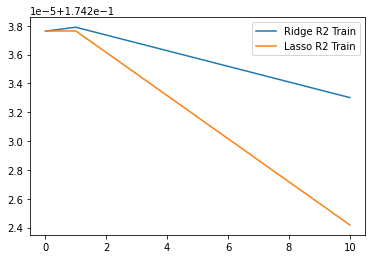

In [28]:
# hyper-parameter 후보
alpha_list = [0.001, 0.01, 0.1, 1, 10]


# 모델 평가와 관련된 라이브러리
from sklearn import metrics
from sklearn.metrics import r2_score # R^2

# 각 모델을 비교하기 위한 평가지표인 r2-score를 저장할 장소
ridge_r2_list_train = []
ridge_r2_list_test = []
lasso_r2_list_train = []
lasso_r2_list_test = []

# 모든 'hyper-parameter'에 대해 하나씩 수행
for alpha in alpha_list:

    # 모델 객체 선언; Ridge(), Lasso()
    # alpha <- hyper-parameter 하나씩 대입
    ridge_model = Ridge(alpha=alpha)
    lasso_model = Lasso(alpha=alpha)
    


    # # 이전처럼 'k-fold학습'을 쓰지 않고, 그냥 학습
    # ridge_model.fit(train_X,train_y)
    # lasso_model.fit(train_X,train_y)
    # #테스트; sklearn.metrics에 있는 r2_score()함수를 가져와 평가
    # ridge_r2_list_test.append(r2_score(test_y,ridge_model.predict(test_X)))
    # lasso_r2_list_test.append(r2_score(test_y,lasso_model.predict(test_X)))


    # kfold 통해 성능평가; 즉, train_set을 8:2로 나누는 것을 10번 반복해서 학습을 진행하는 것이다.
    # cross_val_score()에서 scoring='r2'로 두고 평가
    # 즉, train_set만을 가지고 학습 및 평가(검증)를 진행한다.
    # test_set은 사용하지 않는다.
    ridge_r2_list_train.append(np.mean(cross_val_score(ridge_model,train_X,train_y,scoring='r2',cv=10)))
    lasso_r2_list_train.append(np.mean(cross_val_score(lasso_model,train_X,train_y,scoring='r2',cv=10)))
    
    

plt.plot(alpha_list, ridge_r2_list_train, label='Ridge R2 Train')
plt.plot(alpha_list, lasso_r2_list_train, label='Lasso R2 Train')

plt.legend()

# r2지표는 높을수록 좋음으로, Ridge&Lasso 모두 alpha=0.001일 때 가장 모델의 성능이 좋다.

In [29]:
# 차례로 'alpha = [0.001, 0.01, 0.1, 1, 10]'을 했을 때, Ridge모델에 대한 r2평가지표
ridge_r2_list_train

[0.1742376227931135,
 0.17423762613011207,
 0.17423765866481328,
 0.17423790151640048,
 0.1742330210945286]

In [30]:
# 차례로 'alpha = [0.001, 0.01, 0.1, 1, 10]'을 했을 때, Lasso모델에 대한 r2평가지표
lasso_r2_list_train

[0.1742376225980382,
 0.1742376241741175,
 0.17423763858041302,
 0.17423764718570547,
 0.17422418785793625]

In [31]:
# 가장 성능이 좋은 모델의 hyper-parameter 확인

idx1 = np.array(ridge_r2_list_train).argsort()[::-1][0] # 가장 큰 것의 index
idx2 = np.array(lasso_r2_list_train).argsort()[::-1][0] # 가장 큰 것의 index

print('Ridge best alpha :', alpha_list[idx1])
print('Lasso best alpha :', alpha_list[idx2])

Ridge best alpha : 1
Lasso best alpha : 1


In [32]:
# 각각 alpha = 0.1, 0.001으로 두고, ridge와 lasso 적합

# 모델 객체 선언, 이 때 위에서 구한 최적의 hyper-parameter를 넣어준다.
ridge = Ridge(alpha=0.1) # 'fit_intercept=True' : 절편을 넣어줄지에 대한 여부
lasso = Lasso(alpha=0.001)

# 모델 학습; 이번에는 학습데이터를 학습&검증데이터로 나누는 것이 아닌
# 학습데이터로 학습하고, 테스트데이터로 테스트를 한다.
ridge.fit(train_X, train_y)
lasso.fit(train_X, train_y)

# 모델 평가
# R^2; r2_score
# 여기서 매우 조심해야할 사항이 있다.
# 그것은 바로 r2_score()와 mean_squared_error() 모두 인자의 순서를 주의해서 넣어주어야한다는 것이다.
# 모두 (정닶값,예측값) 순으로 넣어주어야한다.
# mse는 어차피 같은 값이 나오지만, r2_score는 조심해야한다.
print("R square score for Ridge model : {:.5f}".format(r2_score(test_y, ridge.predict(test_X))))
print("R square score for Lasso model : {:.5f}".format(r2_score(test_y, lasso.predict(test_X))))

# MSE; mean_squared_error
print("MSE for Ridge model : {:.5f}".format(mean_squared_error(test_y, ridge.predict(test_X))))
print("MSE for Lasso model : {:.5f}".format(mean_squared_error(test_y, lasso.predict(test_X))))

R square score for Ridge model : 0.17644
R square score for Lasso model : 0.17644
MSE for Ridge model : 4322046045.45328
MSE for Lasso model : 4322045877.39498


RMSE: 65742.270, MAE: 36781.956


<BarContainer object of 2 artists>

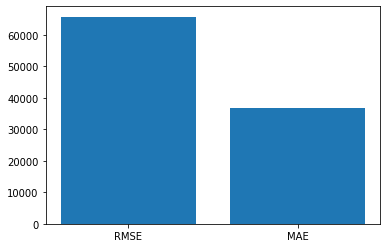

In [33]:
pred = ridge.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

RMSE: 65742.269, MAE: 36782.055


<BarContainer object of 2 artists>

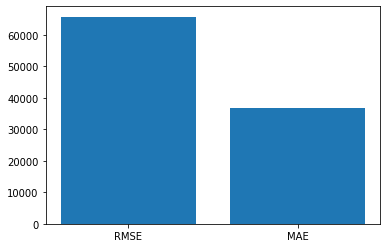

In [34]:
pred = lasso.predict(test_X) # 구한 회귀계수로 모델을 만들고, test_X로 test_y값을 예측한다.

result = evaluate_regr(test_y, pred) # 실제 값인 test_y과 예측값인 pred를 비교한다. 이 때, 회귀와 관련된 평가지표를 사용
plt.bar(['RMSE','MAE'], result)

Lasso가 RMSE 더 낮고, R2_score는 동일. 
따라서 Lasso 선택


## 변수 중요도

1. 스케일링 없이

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


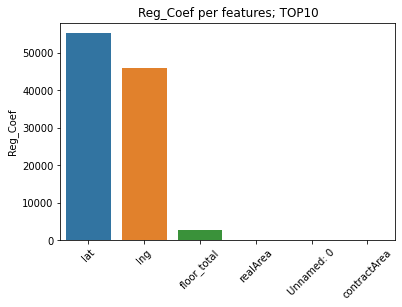

In [35]:
# 표준화한 회귀계수의 절댓값
coef = lasso.coef_
coef_abs = np.abs(coef)

# 회귀계수의 절댓값 크기 index
idx = coef_abs.argsort()[::-1]

# 회귀계수의 절댓값을 큰 순서대로 정렬
coef_abs = coef_abs[idx]

# 회귀계수의 독립변수이름을 큰 순서대로 정렬
name = X3_features.head(1).columns[idx].values

# top10
sns.barplot(name[0:10], coef_abs[0:10])
plt.xticks(rotation=45)
plt.ylabel('Reg_Coef')
plt.title('Reg_Coef per features; TOP10')
plt.show()

2. min-max scaling

In [36]:
from sklearn.preprocessing import MinMaxScaler

total_data = pd.concat([X3_features, y_label], axis=1)

scaler = MinMaxScaler()
scaler.fit(total_data)
trans_data = scaler.transform(total_data)

# numpy -> df
trans_data_df = pd.DataFrame(data=trans_data, columns=total_data.columns)
trans_data_df.head(1) # 0~1 사이의 값들을 가짐을 확인할 수 있다.

,Unnamed: 0,lat,lng,floor_total,contractArea,realArea,deposit
0,0.0,0.957812,0.627131,0.00489,0.000059,0.005172,0.02625


3. standard scailing

In [37]:
from sklearn.preprocessing import StandardScaler

total_data = pd.concat([X3_features, y_label], axis=1)

scaler = StandardScaler()
scaler.fit(total_data)
trans_data = scaler.transform(total_data)

# numpy -> df
trans_data_df = pd.DataFrame(data=trans_data, columns=total_data.columns)
trans_data_df.head(1) # 0~1 사이의 값들을 가짐을 확인할 수 있다.

,Unnamed: 0,lat,lng,floor_total,contractArea,realArea,deposit
0,-1.731846,2.392076,0.630857,-0.755197,-0.011043,-0.124472,0.180513


In [38]:
lasso.coef_

array([ 2.36190457e-01, -5.52418039e+04,  4.59170811e+04,  2.71837396e+03,
        2.16655377e-02,  6.57630018e+01])